## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


In [38]:
X.shape[0]

178

**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [39]:
X.isna().sum().any()

False

пропусков нет

In [40]:
cat_features_mask = (X.dtypes == "object").values
cat_features_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False])

категориальных признаков нет

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [41]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
import random

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random.seed(40), stratify = y, test_size=0.3)

In [51]:
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [41 50 33]
Количество строк в y_test по классам: [18 21 15]


использование аргумента stratify важно для сохранения баланса по классам - то есть для того, чтобы и в тестовой, и в тренировочной выборках сохранялись те же пропорции классов, что и в исходной выборке

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [53]:
X_train_am = X_train[["alcohol","magnesium"]]
X_test_am = X_test[["alcohol","magnesium"]]

scaler = StandardScaler()
scaled_X_train_am = scaler.fit_transform(X_train_am)
scaled_X_test_am = scaler.fit_transform(X_test_am)

list = [1, 3, 5, 10, 15, 25]
print('NN    Train   Test')
for k in list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(scaled_X_train_am, y_train)
    y_predicted_train = knn.predict(scaled_X_train_am)
    knn.fit(scaled_X_test_am, y_test)
    y_predicted_test = knn.predict(scaled_X_test_am)
    train_accuracy = np.mean(y_train == y_predicted_train)
    test_accuracy = np.mean(y_test == y_predicted_test)
    print(f"k = {k}; {train_accuracy:.3f}; {test_accuracy:.3f} ")

NN    Train   Test
k = 1; 1.000; 1.000 
k = 3; 0.790; 0.870 
k = 5; 0.750; 0.778 
k = 10; 0.758; 0.778 
k = 15; 0.702; 0.833 
k = 25; 0.694; 0.741 


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [32]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [33]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

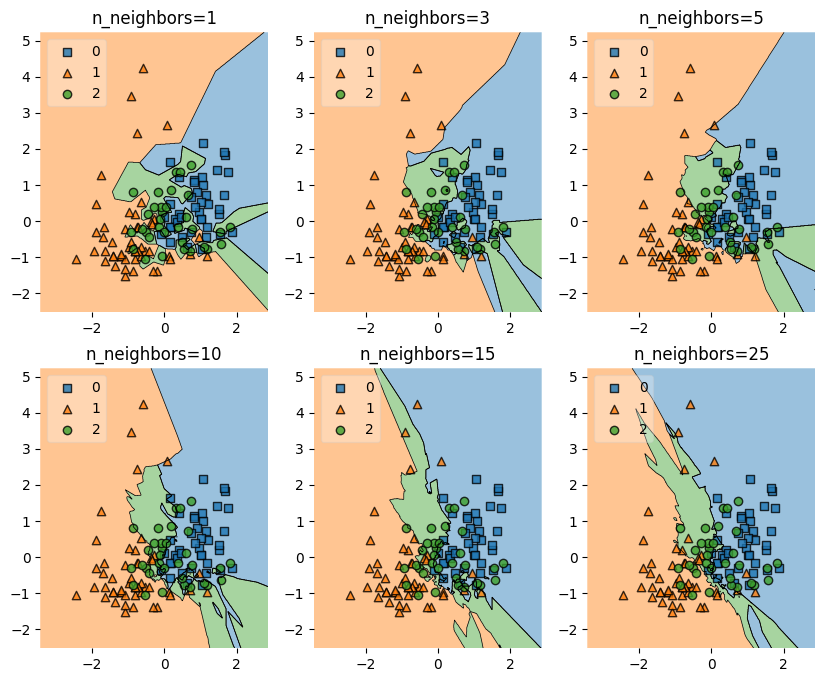

In [54]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(10,8))

y = np.array(y_train)
X = np.array(scaled_X_train_am)
labels = ['n_neighbors=1','n_neighbors=3','n_neighbors=5','n_neighbors=10','n_neighbors=15','n_neighbors=25']

for n, lab, grd in zip(list, labels, itertools.product([0, 1, 2], repeat=2)):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(scaled_X_train_am, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=knn, legend=2)
    plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

При k = 1 наблюдается явное переобучение модели, так как модель просто переводит на себя. При k = 3 достигается наибольшая точность в среднем по тестовой и тренировочной выборке, однако решающая поверхность слишком сложная и изрезанная. Выбираем k = 10, средняя точность чуть хуже, чем при k = 3, но решающая поверхность более простая

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

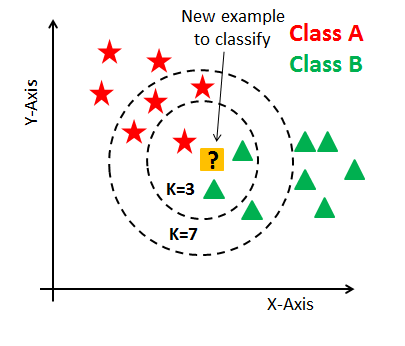

In [68]:
from importlib.abc import ResourceLoader
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
        self.k = k

    def fit(self, X, y):
      self.X_train = X
      self.y_train = y

    def predict(self, X):
      y_pred=[]
      for x in X:
        dist = []
        for train in self.X_train:
          dist.append(self.count_distance(x, train))
        indices = np.argsort(dist)[:self.k]
        nearest = []
        for k in indices:
          nearest.append(self.y_train[k])
        most_common = Counter(nearest).most_common(1)
        res = most_common[0][0]
        y_pred.append(res)
      return np.array(y_pred)

    def count_distance(self, x, y):
      return np.sqrt(np.sum((x - y)**2))

In [69]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [70]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [84]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [85]:
data.isna().sum().any()

False

пропусков нет. Столбец unnamed бессмысленный, так как это просто нумерация строк, она есть автоматическая

In [86]:
del data['Unnamed: 0']

**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [87]:
numeric = data.select_dtypes(include=['float64', 'int64'])
matrix = numeric.corrwith(data['price'])
matrix

carat    0.921591
depth   -0.010647
table    0.127134
price    1.000000
x        0.884435
y        0.865421
z        0.861249
dtype: float64

carat, x(длина), y(ширина), z(глубина)

**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [88]:
df = pd.get_dummies(data, drop_first=True)
df

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,0,1,0,...,0,0,0,0,1,0,0,0,0,0
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,1,0,0,...,0,0,0,0,1,0,0,0,0,0
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,0,0,1,...,1,0,0,0,0,1,0,0,0,0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [89]:
X = df.drop('price',axis=1)
y = df['price']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random.seed(30), test_size=0.3)

здесь мы не можем использовать stratify, так как целевая переменная вещественная

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [91]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

In [93]:
lr = LinearRegression().fit(X_train, y_train)
print(f"Train: {mean_squared_error(y_train, lr.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, lr.predict(X_test))}")

Train: 1286163.812309072
Test: 1258867.4631870217


**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [94]:
coef = lr.coef_
for i, coef in enumerate(coef):
    print(f"{X.columns[i]}: {coef}")

carat: 5289.492429002299
depth: -92.9024534077272
table: -58.515537876975976
x: -1083.513916465426
y: 1.3218282499205116
z: -36.67653371974546
cut_Good: 162.25412221337658
cut_Ideal: 400.43330134573944
cut_Premium: 331.5834341352609
cut_Very Good: 297.95381484990344
color_E: -78.53073515477381
color_F: -100.58366088559968
color_G: -193.29665378094708
color_H: -351.7640763572447
color_I: -435.8538131324985
color_J: -535.9536978809897
clarity_IF: 941.9649634828266
clarity_SI1: 1547.8407358913253
clarity_SI2: 999.5003028310093
clarity_VS1: 1626.160009730922
clarity_VS2: 1762.471188700008
clarity_VVS1: 1245.234086176241
clarity_VVS2: 1419.1896577742023


Оценка коэффициента carat по модулю на порядок превышают оценки прочих вещественных переменных

**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [100]:
lasso = Lasso(10.0).fit(X_train, y_train)
print("Lasso")
print(f"Train: {mean_squared_error(y_train, lasso.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, lasso.predict(X_test))}")
coef_lasso = lasso.coef_
for i, coef in enumerate(coef_lasso):
    print(f"{X.columns[i]}: {coef}")

ridge = Ridge(10.0).fit(X_train, y_train)
print("\nRidge")
print(f"Train: {mean_squared_error(y_train, ridge.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, ridge.predict(X_test))}")
coef_ridge = ridge.coef_
for i, coef in enumerate(coef_ridge):
    print(f"{X.columns[i]}: {coef}")

Lasso
Train: 1344827.8771481125
Test: 1329146.7735777067
carat: 4781.38525928934
depth: -97.63572279649753
table: -68.95572811653794
x: -612.9845336522765
y: -0.0
z: -41.982572847420684
cut_Good: 36.72852985235963
cut_Ideal: 194.73862970870013
cut_Premium: 144.58345815301104
cut_Very Good: 127.75133470438657
color_E: -7.368409641491491
color_F: -35.06765523507066
color_G: -117.1713689686345
color_H: -279.60566289980164
color_I: -363.9625096834169
color_J: -476.63893343921006
clarity_IF: 642.296966267247
clarity_SI1: 846.5885106009534
clarity_SI2: 390.1572740768374
clarity_VS1: 1031.60921038807
clarity_VS2: 1079.3745088297444
clarity_VVS1: 829.5511361983612
clarity_VVS2: 941.5670914541246

Ridge
Train: 1286285.8951168936
Test: 1259793.1974221983
carat: 5250.426406286397
depth: -91.00448962327403
table: -58.62662982598453
x: -1040.7507501666796
y: -0.6036357748936962
z: -40.51611629869486
cut_Good: 162.77345947027382
cut_Ideal: 401.5390637856306
cut_Premium: 332.49912845598465
cut_Very G

MSE и на тестовой, и на тренировочной выборках увеличились, у ridge увеличился меньше, коэффициенты не сильно уменьшились, проблема мультиколлинеарности не решилась (она была сильно значима и в изначальной регрессии), carat также сильно влияет на price

**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

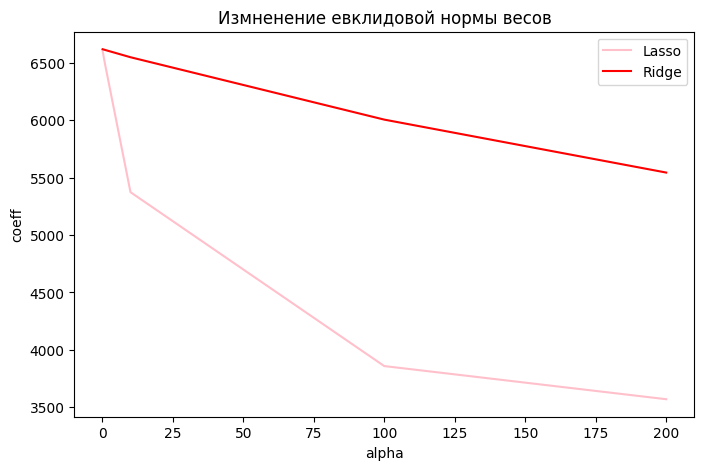

In [104]:
lasso_alpha = []
ridge_alpha = []
alpha =  [0.1, 1, 10, 100, 200]
for i in alpha:
  lasso = Lasso(i).fit(X_train, y_train)
  ridge = Ridge(i).fit(X_train, y_train)
  lasso_alpha.append(np.linalg.norm(lasso.coef_))
  ridge_alpha.append(np.linalg.norm(ridge.coef_))

plt.figure(figsize=(8, 5))
plt.plot(alpha, lasso_alpha, label='Lasso', color = 'pink')
plt.plot(alpha, ridge_alpha, label='Ridge', color = 'red')
plt.xlabel('alpha')
plt.ylabel('coeff')
plt.title('Измненение евклидовой нормы весов')
plt.legend()
plt.show()

Метод Lasso агрессивнее уменьшает веса, его часто используют для отбора признаков, так как она эффективно выявляет наиболее важные признаки для прогнозирования целевой переменной, уменьшая или приавниваня некоторые коэффициенты к 0. Это позволяет создавать более простые и интерпретируемые модели, помогает предотвратить переобучение модели и справиться с проблемой мультиколлинеарности.



**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

 Матрица ошибок:

In [114]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(alphas=alpha, cv=5).fit(X_train, y_train)
lasso_cv.mse_path_

array([[2134330.4700848 , 2132490.76059342, 2137528.79322191,
        2221894.96007655, 2191584.72483782],
       [1737764.55841951, 1806253.07372153, 1740501.21743542,
        1860447.01457805, 1826674.97331785],
       [1290179.45206226, 1391778.75490968, 1278796.80009124,
        1412910.98479995, 1381674.38507362],
       [1236033.62750353, 1328861.55043911, 1222179.50816054,
        1346743.46203299, 1332544.93532202],
       [1235530.67696731, 1327957.08083625, 1221860.65051123,
        1346341.65276301, 1333323.9499436 ]])

In [115]:
mean_mse = np.mean(lasso_cv.mse_path_, axis=1)
best = lasso_cv.alphas_[np.argmin(mean_mse)]
print(best)

0.1


Наибольшее качество достигается при α = 0.1



**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [116]:
lasso = Lasso(0.1).fit(X_train, y_train)
coef = lasso.coef_
for i, coef in enumerate(coef):
  print(f"{X.columns[i]}: {coef}")

carat: 5284.45314921393
depth: -92.98543023336754
table: -58.62753157842118
x: -1077.7698869538854
y: 0.0
z: -36.53915868466906
cut_Good: 161.0338651728123
cut_Ideal: 398.4287008369848
cut_Premium: 329.74449258839996
cut_Very Good: 296.30610219377843
color_E: -77.81817766112911
color_F: -99.92819575106368
color_G: -192.53567740597364
color_H: -351.04097645037746
color_I: -435.1350410942384
color_J: -535.3612645137197
clarity_IF: 938.9247481491938
clarity_SI1: 1540.7234066688404
clarity_SI2: 993.3179300573066
clarity_VS1: 1620.1293983242501
clarity_VS2: 1755.5393300017251
clarity_VVS1: 1241.0163405018966
clarity_VVS2: 1414.3441171283275


наиболее информативным признаком все также остается carat (что логично, количество карат - масса алмаза - напрямую влияет на его цену), коэффициент при у (ширина алмаза) занулился, большие значения коэффициентов наблюдаются у качественной переменной clarify - степень отсутствия внутренних дефектов, это также очевидно влияет на цену. отрицательные коэффициенты у х (длина) и z (глубина) могли образоваться из-за мультиколлинеарности между ними и carat, модель пытается скомпенсировать сильное влияние carat. на цену также влияет качество огранки, цвет (чем лучше цвет - тем больше коэффициент, однако он также отрицательный возможно из-за мультиколлинеарности). table (ширина вершины ромба относительно самого широкого места) и depth (относительная глубина) имеют относительно небольшие коэффициенты

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [117]:
print(f"Test: {mean_squared_error(y_test, lasso.predict(X_test))}")

Test: 1259030.3871537517


значение MSE для обычной линейной регрессии получилось немного меньше, чем у обученной Lasso-регрессии, возможно в нашем случае лучше использовать обычную линейную регрессию, так как lasso слишком занижает важные коэффициенты